# Cargar datos

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dat = pd.read_csv('dataset/dataset_elpino.csv', sep=';', on_bad_lines='skip')
cie10 = pd.read_excel("dataset/CIE-10.xlsx")
precios = pd.read_excel("dataset/IR-GRD V3.1 CON PRECIOS FONASA 2016.xlsx", dtype={'IR-GRD CÓDIGO': str})

dat

,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),Diag 11 Secundario (cod+des),Diag 12 Secundario (cod+des),Diag 13 Secundario (cod+des),Diag 14 Secundario (cod+des),Diag 15 Secundario (cod+des),Diag 16 Secundario (cod+des),Diag 17 Secundario (cod+des),Diag 18 Secundario (cod+des),Diag 19 Secundario (cod+des),Diag 20 Secundario (cod+des),Diag 21 Secundario (cod+des),Diag 22 Secundario (cod+des),Diag 23 Secundario (cod+des),Diag 24 Secundario (cod+des),Diag 25 Secundario (cod+des),Diag 26 Secundario (cod+des),Diag 27 Secundario (cod+des),Diag 28 Secundario (cod+des),Diag 29 Secundario (cod+des),Diag 30 Secundario (cod+des),Diag 31 Secundario (cod+des),Diag 32 Secundario (cod+des),Diag 33 Secundario (cod+des),Diag 34 Secundario (cod+des),Diag 35 Secundario (cod+des),Proced 01 Principal (cod+des),Proced 02 Secundario (cod+des),Proced 03 Secundario (cod+des),Proced 04 Secundario (cod+des),Proced 05 Secundario (cod+des),Proced 06 Secundario (cod+des),Proced 07 Secundario (cod+des),Proced 08 Secundario (cod+des),Proced 09 Secundario (cod+des),Proced 10 Secundario (cod+des),Proced 11 Secundario (cod+des),Proced 12 Secundario (cod+des),Proced 13 Secundario (cod+des),Proced 14 Secundario (cod+des),Proced 15 Secundario (cod+des),Proced 16 Secundario (cod+des),Proced 17 Secundario (cod+des),Proced 18 Secundario (cod+des),Proced 19 Secundario (cod+des),Proced 20 Secundario (cod+des),Proced 21 Secundario (cod+des),Proced 22 Secundario (cod+des),Proced 23 Secundario (cod+des),Proced 24 Secundario (cod+des),Proced 25 Secundario (cod+des),Proced 26 Secundario (cod+des),Proced 27 Secundario (cod+des),Proced 28 Secundario (cod+des),Proced 29 Secundario (cod+des),Proced 30 Secundario (cod+des),Edad en años,Sexo (Desc),GRD
0,A41.8 - Otras septicemias especificadas,B37.6 - Endocarditis debida a candida (I39.8*),"I39.8 - Endocarditis, válvula no especificada,...",N10 - Nefritis tubulointersticial aguda,B96.1 - Klebsiella pneumoniae [K. pneumoniae] ...,L89.9 - Úlcera de decúbito y area de presión n...,L08.9 - Infección local de la piel y del tejid...,B96.2 - Escherichia coli [E. coli] como causa ...,A41.5 - Sepsis por otros organnismos Gram nega...,J86.9 - Piotórax sin fístula,"U07.1 - COVID-19, virus identificado",Y95 - Afección nosocomial,"N18.5 - Enfermedad renal crónica, estadio 5",E87.1 - Hiposmolaridad e hiponatremia,D64.9 - Anemia de tipo no especificado,"G82.2 - Paraplejía, no especificada","N31.9 - Disfunción neuromuscular de la vejiga,...",I10 - Hipertensión esencial (primaria),K70.4 - Insuficiencia hepática alcohólica,F19.2 - Trastornos mentales y del comportamien...,F10.2 - Trastornos mentales y del comportamien...,"E46 - Desnutrición proteicocalórica, no especi...","G40.9 - Epilepsia, tipo no especificado","L21.9 - Dermatitis seborreica, no especificada",Z93.5 - Cistostomía,Z93.3 - Colostomía,Z99.2 - Dependencia de diálisis renal,Z91.6 - Historia personal de otro trauma físico,-,-,-,-,-,-,-,"86.28 - DESBRIDAMIENTO HERIDA,INFECCION O QUEM...",34.91 - TORACOCENTESIS,88.38 - TOMOGRAFIA AXIAL COMPUTERIZADA OTRA,87.41 - TOMOGRAFIA AXIAL COMPUTERIZADA TORAX,88.75 - ECOGRAFIA APARATO URINARIO,88.01 - TOMOGRAFIA AXIAL COMPUTERIZADA ABDOMEN,88.43 - ARTERIOGRAFIA ARTERIA PULMONAR,88.41 - ARTERIOGRAFIA ARTERIA CEREBRAL,87.44 - RADIOGRAFIA TORAX RUTINARIA,99.29 - INYECCION SUSTANCIA TERAPEUTICA O PROF...,99.19 - INYECCION ANTICOAGULANTE,99.18 - INYECCION ELECTROLITO,99.21 - INYECCION ANTIBIOTICO,99.26 - INYECCION TRANQUILIZANTE,99.23 - INYECCION ESTEROIDE,93.94 - AEROSOLTERAPIA,89.52 - ELECTROCARDIOGRAFIA,90.59 - EXAMEN MICROSCOPICO SANGRE.OTRO,89.65 - GASOMETRIA ARTERIA,39.95 - HEMODIALISIS,39.95 - HEMODIALISIS,99.04 - TRANSFUSION CONCENTRADO HEMATIES,90.39 - EXAMEN MICROSCOPICO ORL.OTRO,99.84 - AISLAMIENTO,88.7

## Limpiar columnas del set de datos principal y quedarse sólo con los códigos

In [4]:
# Limpieza: crear copia con solo los códigos de Diagnóstico y Procedimiento
mask = dat.columns.str.startswith(("Diag", "Proced"))
codes_df = dat.loc[:, mask].copy()

# Extraer la parte antes del primer guión
codes_df = codes_df.apply(
    lambda col: col.astype(str).str.split(r"\s*-\s*", n=1, regex=True).str[0].str.strip()
)

# Normalizar valores vacíos
codes_df = codes_df.applymap(lambda v: 0 if (pd.isna(v) or str(v).strip() in ('', '-')) else str(v).strip())
codes_df['Edad'] = pd.to_numeric(dat['Edad en años'], errors='coerce').astype('Int64')
codes_df['Sexo'] = dat['Sexo (Desc)'].replace({'Hombre': int(1), 'Mujer':int(0)}).astype('Int64')

# Procesar GRD
grd = dat['GRD'].astype(str).str.strip()
split = grd.str.split(r"\s*-\s*", n=1, regex=True)
codes_df['GRD'] = dat['GRD'].replace({'': pd.NA}).astype('string')
codes_df['GRD_codigo'] = split.str[0].replace({'': pd.NA}).astype('string')
codes_df['GRD_descripcion'] = split.str[1].replace({None: pd.NA}).astype('string')
codes_df['GRD_severidad'] = codes_df['GRD_codigo'].astype(str).str.extract(r"(\d)$", expand=False)
codes_df['GRD_final'] = codes_df['GRD_codigo'].astype(str).str.replace(r"(\d)$", "", regex=True).replace({'': pd.NA}).astype('string')

codes_df.to_csv('dataset/dataset_elpino_codes.csv', index=False)
codes_df

<positron-console-cell-4>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
<positron-console-cell-4>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),Diag 11 Secundario (cod+des),Diag 12 Secundario (cod+des),Diag 13 Secundario (cod+des),Diag 14 Secundario (cod+des),Diag 15 Secundario (cod+des),Diag 16 Secundario (cod+des),Diag 17 Secundario (cod+des),Diag 18 Secundario (cod+des),Diag 19 Secundario (cod+des),Diag 20 Secundario (cod+des),Diag 21 Secundario (cod+des),Diag 22 Secundario (cod+des),Diag 23 Secundario (cod+des),Diag 24 Secundario (cod+des),Diag 25 Secundario (cod+des),Diag 26 Secundario (cod+des),Diag 27 Secundario (cod+des),Diag 28 Secundario (cod+des),Diag 29 Secundario (cod+des),Diag 30 Secundario (cod+des),Diag 31 Secundario (cod+des),Diag 32 Secundario (cod+des),Diag 33 Secundario (cod+des),Diag 34 Secundario (cod+des),Diag 35 Secundario (cod+des),Proced 01 Principal (cod+des),Proced 02 Secundario (cod+des),Proced 03 Secundario (cod+des),Proced 04 Secundario (cod+des),Proced 05 Secundario (cod+des),Proced 06 Secundario (cod+des),Proced 07 Secundario (cod+des),Proced 08 Secundario (cod+des),Proced 09 Secundario (cod+des),Proced 10 Secundario (cod+des),Proced 11 Secundario (cod+des),Proced 12 Secundario (cod+des),Proced 13 Secundario (cod+des),Proced 14 Secundario (cod+des),Proced 15 Secundario (cod+des),Proced 16 Secundario (cod+des),Proced 17 Secundario (cod+des),Proced 18 Secundario (cod+des),Proced 19 Secundario (cod+des),Proced 20 Secundario (cod+des),Proced 21 Secundario (cod+des),Proced 22 Secundario (cod+des),Proced 23 Secundario (cod+des),Proced 24 Secundario (cod+des),Proced 25 Secundario (cod+des),Proced 26 Secundario (cod+des),Proced 27 Secundario (cod+des),Proced 28 Secundario (cod+des),Proced 29 Secundario (cod+des),Proced 30 Secundario (cod+des),Edad,Sexo,GRD,GRD_codigo,GRD_descripcion,GRD_severidad,GRD_final
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,U07.1,Y95,N18.5,E87.1,D64.9,G82.2,N31.9,I10,K70.4,F19.2,F10.2,E46,G40.9,L21.9,Z93.5,Z93.3,Z99.2,Z91.6,0,0,0,0,0,0,0,86.28,34.91,88.38,87.41,88.75,88.01,88.43,88.41,87.44,99.29,99.19,99.18,99.21,99.26,99.23,93.94,89.52,90.59,89.65,39.95,39.95,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,40,1,184103 - MH SEPTICEMIA W/MCC,184103,MH SEPTICEMIA W/MCC,3,18410
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,J15.1,Y95,N17.9,G62.8,M54.19,L89.3,F13.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.1,86.28,96.72,93.90,89.7,88.01,87.41,34.04,88.43,93.96,93.94,90.39,99.84,99.29,99.19,00.17,99.21,99.18,99.26,99.23,89.65,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,53,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,J99.8,J69.0,A49.0,L89.3,B96.4,E11.1,E87.0,E87.6,E83.5,N17.9,K75.9,D64.9,E46,E87.3,J44.8,J98.4,U07.1,Z29.0,Z01.7,Z20.8,Z88.0,Z72.0,0,0,0,86.22,54.59,96.72,31.1,45.13,87.41,87.03,88.01,88.43,88.72,33.22,87.44,89.7,90.59,00.17,99.21,99.04,93.96,91.83,90.43,38.93,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,65,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,K44.9,K26.9,B96.2,R57.1,K80.2,L89.0,F12.2,Z91.1,Z99.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.19,39.98,86.28,54.62,96.72,96.04,87.41,88.01,88.38,88.41,88.47,87.44,88.75,88.79,88.72,89.52,45.13,38.93,38.91,38.95,39.95,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,61,1,041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...,041023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,3,04102
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,B96.2,Y95,D62,N17.9,E87.6,K70.4,I85.9,G93.4,R18,I10,F10.2,F19.2,0,0,0,0,0,0,0,0,0,0,0,0,0,54.11,45.90,46.73,46.20,86.28,54.19,8

## Cruzar con datos CIE y precios

In [5]:
codes_df_cie = codes_df.merge(cie10, left_on='Diag 01 Principal (cod+des)', right_on='Código', how='left')
codes_df_cie_precio = codes_df_cie.merge(precios, how="left", left_on='GRD_codigo', right_on='IR-GRD CÓDIGO')
codes_df_cie_precio

,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),Diag 11 Secundario (cod+des),Diag 12 Secundario (cod+des),Diag 13 Secundario (cod+des),Diag 14 Secundario (cod+des),Diag 15 Secundario (cod+des),Diag 16 Secundario (cod+des),Diag 17 Secundario (cod+des),Diag 18 Secundario (cod+des),Diag 19 Secundario (cod+des),Diag 20 Secundario (cod+des),Diag 21 Secundario (cod+des),Diag 22 Secundario (cod+des),Diag 23 Secundario (cod+des),Diag 24 Secundario (cod+des),Diag 25 Secundario (cod+des),Diag 26 Secundario (cod+des),Diag 27 Secundario (cod+des),Diag 28 Secundario (cod+des),Diag 29 Secundario (cod+des),Diag 30 Secundario (cod+des),Diag 31 Secundario (cod+des),Diag 32 Secundario (cod+des),Diag 33 Secundario (cod+des),Diag 34 Secundario (cod+des),Diag 35 Secundario (cod+des),Proced 01 Principal (cod+des),Proced 02 Secundario (cod+des),Proced 03 Secundario (cod+des),Proced 04 Secundario (cod+des),Proced 05 Secundario (cod+des),...,Proced 12 Secundario (cod+des),Proced 13 Secundario (cod+des),Proced 14 Secundario (cod+des),Proced 15 Secundario (cod+des),Proced 16 Secundario (cod+des),Proced 17 Secundario (cod+des),Proced 18 Secundario (cod+des),Proced 19 Secundario (cod+des),Proced 20 Secundario (cod+des),Proced 21 Secundario (cod+des),Proced 22 Secundario (cod+des),Proced 23 Secundario (cod+des),Proced 24 Secundario (cod+des),Proced 25 Secundario (cod+des),Proced 26 Secundario (cod+des),Proced 27 Secundario (cod+des),Proced 28 Secundario (cod+des),Proced 29 Secundario (cod+des),Proced 30 Secundario (cod+des),Edad,Sexo,GRD,GRD_codigo,GRD_descripcion,GRD_severidad,GRD_final,Versión,Código,Descripción,Categoría,Sección,Capítulo,IR-GRD CÓDIGO,NOMBRE DEL GRUPO GRD,Peso v31,CDM_COD,CATEGORÍA DIAGNÓSTICA MAYOR CDM,TIPO_COD,TIPO GRD,Precio FONASA 2016
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,U07.1,Y95,N18.5,E87.1,D64.9,G82.2,N31.9,I10,K70.4,F19.2,F10.2,E46,G40.9,L21.9,Z93.5,Z93.3,Z99.2,Z91.6,0,0,0,0,0,0,0,86.28,34.91,88.38,87.41,88.75,...,99.18,99.21,99.26,99.23,93.94,89.52,90.59,89.65,39.95,39.95,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,40,1,184103 - MH SEPTICEMIA W/MCC,184103,MH SEPTICEMIA W/MCC,3,18410,CIE-v2013,A41.8,Otras septicemias especificadas,A41 OTRAS SEPSIS,A30-A49 OTRAS ENFERMEDADES BACTERIANAS,Cap.01 CIERTAS ENFERMEDADES INFECCIOSAS Y PAR...,184103,MH SEPTICEMIA W/MCC,1.4032,18,ENFERMEDADES INFECCIOSAS Y PARASITARIAS SISTÉM...,MH,MÉDICO HOSPITALIZADO,2.104800e+06
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,J15.1,Y95,N17.9,G62.8,M54.19,L89.3,F13.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.1,86.28,96.72,93.90,89.7,...,90.39,99.84,99.29,99.19,00.17,99.21,99.18,99.26,99.23,89.65,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,53,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101,CIE-v2013,U07.1,"COVID-19, virus identificado",U07 USO EMERGENTE DE U07,U00-U49 ASIGNACION PROVISIONAL DE NUEVAS ENFE...,Cap.22 CÓDIGOS PARA SITUACIONES ESPECIALES (U...,041013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,J99.8,J69.0,A49.0,L89.3,B96.4,E11.1,E87.0,E87.6,E83.5,N17.9,K75.9,D64.9,E46,E87.3,J44.8,J98.4,U07.1,Z29.0,Z01.7,Z20.8,Z88.0,Z72.0,0,0,0,86.22,54.59,96.72,31.1,45.13,...,87.44,89.7,90.59,00.17,99.21,99.04,93.96,91.83,90.43,38.93,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,65,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101,CIE-v2013,K56.5,Adherencias [bridas] intestinales con obstrucción,K56 ILEO PARALÍTICO Y OBSTRUCCIÓN INTESTINAL S...,K55-K64 OTRAS ENF

## Codificar columnas Diag y Proced a enteros

In [6]:
# Obtener columnas de diagnóstico y procedimiento
diag_proced_cols = [c for c in codes_df_cie_precio.columns if c.startswith("Diag") or c.startswith("Proced")]
encoded_df = codes_df_cie_precio.copy()

# Función para normalizar valores
def normalize_cell(v):
    if pd.isna(v):
        return pd.NA
    s = str(v).strip()
    return pd.NA if s in ('', '-', '0', 'nan', 'None') else s

# Normalizar y obtener valores únicos
norm_subset = encoded_df[diag_proced_cols].apply(lambda col: col.map(normalize_cell))
uniques = sorted(pd.Series(norm_subset.values.ravel()).dropna().unique().tolist())

# Crear mapeo: 0=NA, 1..n=códigos ordenados
mapping_with_na = {'<NA>': 0}
mapping_with_na.update({code: i+1 for i, code in enumerate(uniques)})

# Codificar y guardar
encoded_subset = norm_subset.apply(lambda col: col.map(lambda v: mapping_with_na.get(v, 0) if pd.isna(v) else mapping_with_na.get(v, 0)))
encoded_subset = encoded_subset.fillna(0).astype(int)
encoded_df[diag_proced_cols] = encoded_subset

mapping_df = pd.DataFrame(list(mapping_with_na.items()), columns=['code', 'int']).sort_values('int')
mapping_df.to_csv('dataset/codes_mapping.csv', index=False)
encoded_df.to_csv('dataset/dataset_elpino_codes_encoded.csv', index=False)

encoded_df

,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),Diag 11 Secundario (cod+des),Diag 12 Secundario (cod+des),Diag 13 Secundario (cod+des),Diag 14 Secundario (cod+des),Diag 15 Secundario (cod+des),Diag 16 Secundario (cod+des),Diag 17 Secundario (cod+des),Diag 18 Secundario (cod+des),Diag 19 Secundario (cod+des),Diag 20 Secundario (cod+des),Diag 21 Secundario (cod+des),Diag 22 Secundario (cod+des),Diag 23 Secundario (cod+des),Diag 24 Secundario (cod+des),Diag 25 Secundario (cod+des),Diag 26 Secundario (cod+des),Diag 27 Secundario (cod+des),Diag 28 Secundario (cod+des),Diag 29 Secundario (cod+des),Diag 30 Secundario (cod+des),Diag 31 Secundario (cod+des),Diag 32 Secundario (cod+des),Diag 33 Secundario (cod+des),Diag 34 Secundario (cod+des),Diag 35 Secundario (cod+des),Proced 01 Principal (cod+des),Proced 02 Secundario (cod+des),Proced 03 Secundario (cod+des),Proced 04 Secundario (cod+des),Proced 05 Secundario (cod+des),...,Proced 12 Secundario (cod+des),Proced 13 Secundario (cod+des),Proced 14 Secundario (cod+des),Proced 15 Secundario (cod+des),Proced 16 Secundario (cod+des),Proced 17 Secundario (cod+des),Proced 18 Secundario (cod+des),Proced 19 Secundario (cod+des),Proced 20 Secundario (cod+des),Proced 21 Secundario (cod+des),Proced 22 Secundario (cod+des),Proced 23 Secundario (cod+des),Proced 24 Secundario (cod+des),Proced 25 Secundario (cod+des),Proced 26 Secundario (cod+des),Proced 27 Secundario (cod+des),Proced 28 Secundario (cod+des),Proced 29 Secundario (cod+des),Proced 30 Secundario (cod+des),Edad,Sexo,GRD,GRD_codigo,GRD_descripcion,GRD_severidad,GRD_final,Versión,Código,Descripción,Categoría,Sección,Capítulo,IR-GRD CÓDIGO,NOMBRE DEL GRUPO GRD,Peso v31,CDM_COD,CATEGORÍA DIAGNÓSTICA MAYOR CDM,TIPO_COD,TIPO GRD,Precio FONASA 2016
0,935,997,1827,2626,1028,2422,2366,1029,934,2082,3827,4243,2651,1400,1249,1672,2675,1780,2273,1473,1433,1359,1623,2371,4522,4521,4548,4509,0,0,0,0,0,0,0,590,78,641,617,657,...,875,877,882,879,787,687,714,693,117,117,864,706,900,654,708,712,736,735,609,40,1,184103 - MH SEPTICEMIA W/MCC,184103,MH SEPTICEMIA W/MCC,3,18410,CIE-v2013,A41.8,Otras septicemias especificadas,A41 OTRAS SEPSIS,A30-A49 OTRAS ENFERMEDADES BACTERIANAS,Cap.01 CIERTAS ENFERMEDADES INFECCIOSAS Y PAR...,184103,MH SEPTICEMIA W/MCC,1.4032,18,ENFERMEDADES INFECCIOSAS Y PARASITARIAS SISTÉM...,MH,MÉDICO HOSPITALIZADO,2.104800e+06
1,3827,2008,3298,3297,3364,4272,4245,2095,2090,2085,2013,4243,2646,1654,2536,2421,1449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,590,837,784,695,...,706,900,883,876,3,877,875,882,879,693,745,620,743,709,736,712,734,833,722,53,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101,CIE-v2013,U07.1,"COVID-19, virus identificado",U07 USO EMERGENTE DE U07,U00-U49 ASIGNACION PROVISIONAL DE NUEVAS ENFE...,Cap.22 CÓDIGOS PARA SITUACIONES ESPECIALES (U...,041013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
2,2223,3374,3373,2073,4243,2012,3833,1025,1034,993,2112,2072,940,2421,1031,1310,1399,1405,1395,2646,2290,1249,1359,1402,2062,2107,3827,4272,4245,4266,4479,4397,0,0,0,587,339,837,51,177,...,620,695,714,3,877,864,788,750,709,107,735,706,900,747,713,882,682,694,693,65,1,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...,041013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,3,04101,CIE-v2013,K56.5,Adherencias [bridas] intestinales con obstrucción,K56 ILEO PARALÍTICO Y OBSTRUCCIÓN INTESTINAL S...,K55-K64 OTRAS ENFERMEDADES DE LOS INTESTINOS,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...,041013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HO

# Análisis exploratorio de datos categoría K (trastornos digestivos)

En el modelo se usan los GRD que tienen más 5 registros, en este caso quedan 29 GRD para análisis

In [11]:
# Ajusta nombres de columnas si difieren: 'Código', 'GRD_final', 'precio_fonasa'
resumen = (
    encoded_df.loc[encoded_df['Código'].str.startswith('K', na=False)]
      .groupby('GRD_final', dropna=False)
      .agg(
          n_registros = ('Código', "size"),
          n_diagnosticos = ('Código', pd.Series.nunique),
          precio_min = ('Precio FONASA 2016', 'min'),
          precio_max = ('Precio FONASA 2016', 'max')
      )
      .assign(diferencia_precio = lambda d: d['precio_max'] - d['precio_min'])
      .sort_values('n_registros', ascending=False)
      .reset_index()
)

resumen.to_excel('dataset/resumen_grd_categoria_K.xlsx', index=False)
resumen

,GRD_final,n_registros,n_diagnosticos,precio_min,precio_max,diferencia_precio
0,07114,492,14,1.417049e+06,2.691245e+06,1.274195e+06
1,06113,320,5,1.196864e+06,1.798531e+06,6.016675e+05
2,06418,213,35,7.308000e+05,1.644300e+06,9.135000e+05
3,07414,132,12,8.698500e+05,1.724250e+06,8.544000e+05
4,06112,99,13,1.313994e+06,2.755148e+06,1.441155e+06
5,07410,87,6,7.785000e+05,1.757700e+06,9.792000e+05
6,06120,83,42,2.020658e+06,5.767045e+06,3.746387e+06
7,07413,80,9,8.019000e+05,1.834650e+06,1.032750e+06
8,07412,80,9,8.071500e+05,1.862400e+06,1.055250e+06
9,06413,73,9,7.984500e+05,1.542300e+06,7.438500e+05


Text(0, 0.5, 'Price CLP')

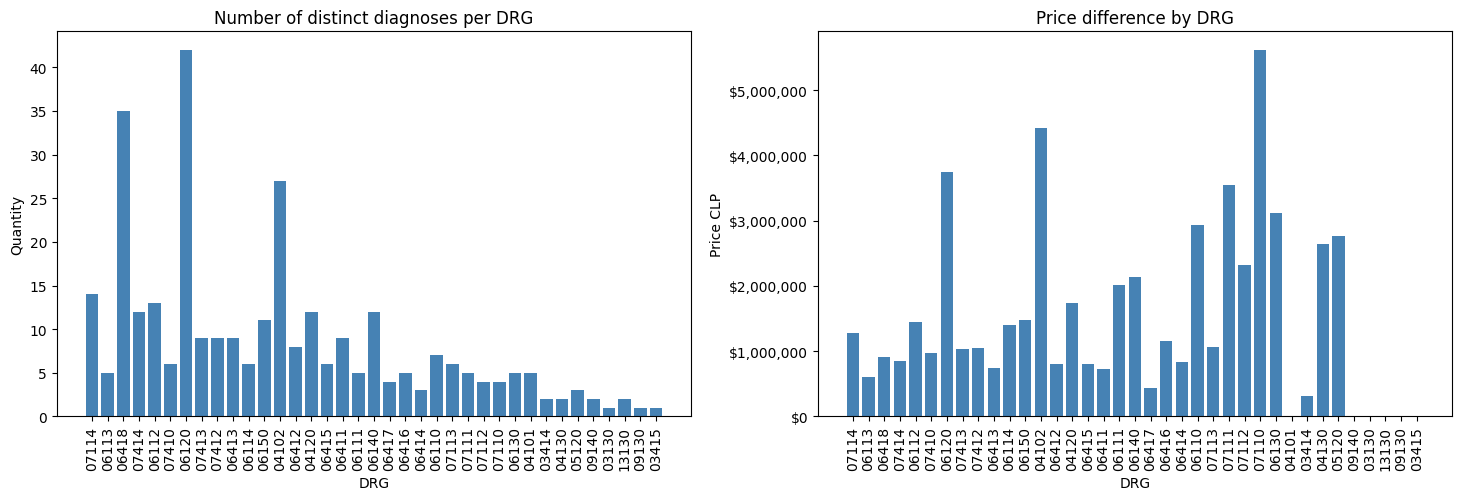

In [10]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# GRD vs n_diagnosticos
axes[0].bar(resumen.GRD_final, resumen.n_diagnosticos, color='steelblue')
axes[0].set_title('Number of distinct diagnoses per DRG')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('DRG')
axes[0].set_ylabel('Quantity')

# GRD vs diferencia precio
## Formateador de etiquetas de precios
fmt = '${x:,.0f}'
tick_formatter = mtick.StrMethodFormatter(fmt)

axes[1].bar(resumen.GRD_final, resumen.diferencia_precio, color='steelblue')
axes[1].set_title('Price difference by DRG')
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_formatter(tick_formatter)
axes[1].set_xlabel('DRG')
axes[1].set_ylabel('Price CLP')